<a href="https://colab.research.google.com/github/jRicciL/Aprendizaje_profundo_tareas_CICESE/blob/master/Seq2seq_word_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq a nivel palabra
## Traductor de oraciones Inglés-Español
### **Tarea 5:** Aprendizaje Profundo - CICESE

> **Estudiante:** [Joel Ricci López](https://github.com/jRicciL), 2021

***

#### Descripción:
Implementar un traductor Seq2Seq a nivel palabras para traducir oraciones del inglés al español.

## Estrategia de solución:
### Primera implementación:
- Se usará la base de datos de frases inglés-español disponible en la web ManyThings

### Descarga de los datos

Montamos Google drive para tener los datos  disponibles desde la cuenta de drive.

In [25]:
from google.colab import drive
 
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/kaggle/nlp'
%cd $root_path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/kaggle/nlp


Ahora procedemos a descargar y leer los datos:


- Para la descarga de la base de datos se implementó el siguiente código:

```python
# Descarga de los datos
!wget http://www.manythings.org/anki/spa-eng.zip

import zipfile
with zipfile.ZipFile(
    f'{root_path}/spa-eng.zip', 'r') as zf:
    zf.extractall(root_path)
```

#### Lectura de los datos

In [26]:
data_path = 'spa.txt'

with open(data_path, 'r', encoding = 'utf-8') as f:
  lines = f.readlines()

print(40*'-', 
      f'\nTotal de pares de oraciones: {len(lines)}\n',
      40*'-')

# Mostramos algunas de las frases
lines[10000:10005]

---------------------------------------- 
Total de pares de oraciones: 128084
 ----------------------------------------


['The air is damp.\tEl aire está húmedo.\tCC-BY 2.0 (France) Attribution: tatoeba.org #1743488 (Spamster) & #1905890 (hayastan)\n',
 'The box is here.\tLa caja está aquí.\tCC-BY 2.0 (France) Attribution: tatoeba.org #9517311 (CK) & #9667671 (Shishir)\n',
 'The boy is kind.\tEl niño es amable.\tCC-BY 2.0 (France) Attribution: tatoeba.org #46327 (CK) & #758526 (Shishir)\n',
 'The boy is nice.\tEl niño es amable.\tCC-BY 2.0 (France) Attribution: tatoeba.org #1414376 (enteka) & #758526 (Shishir)\n',
 'The bus is slow.\tEl autobús es lento.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2002516 (bichodebola) & #2002666 (bichodebola)\n']

## Preparación de los datos
### Vectorización de las oraciones
Comenzamos con la fase de procesamiento de los textos. Se obtendrán los siguientes objetos:

1. 

In [27]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
num_samples = 10000 # Tamaño de la muestra para entrenamiento
start_sample = 0

# Realizamos un muestreo aleatorio de las frases
# para obtenerl las num_samples muestras deseadas
# lines_s = np.random.choice(a = lines, 
#                            size = num_samples, 
#                            replace = False)
lines_s = lines[start_sample: 
                start_sample + num_samples]

# Inicializamos las listas y sets de los 
# textos de entrada y salida
# English texts
input_texts      = []
input_tokenized  = []
# Spanish texts
target_texts     = []
target_tokenized = []
# Conjunto de tokens
input_tokens_set  = set() 
target_tokens_set = set()



def tokenize_spanish(text):
  tokens = word_tokenize(text)
  tokens = [token[1:]
            if token[0] in ("¿","¡") 
            else token
            for token in tokens]
  return tokens

for line in lines_s:
  # Separa los textos en los lenguajes correspondientes
  input_text, target_text, _ = line.split('\t')
  # Lowercase
  input_text, target_text = input_text.lower(), target_text.lower()
  # Delimita los textos target con los siguientes tokens
  target_text = 'START ' + target_text + ' END'

  # Agrega a las listas correspondientes
  input_texts.append(input_text)
  target_texts.append(target_text)

  # Realizamos la fase de tokenización de los textos
  in_tokens  = word_tokenize(input_text)
  input_tokenized.append(in_tokens)

  tar_tokens = tokenize_spanish(target_text)
  target_tokenized.append(tar_tokens)

  # Adicionalmente, añadimos los tokens nuevos al
  # conjunto de tokens correspondiente
  for token in in_tokens:
    input_tokens_set.add(token)
  
  for token in tar_tokens:
    target_tokens_set.add(token)
  

### Exploramos un poco los conjuntos de caracteres

In [29]:
# Número de tokens en cada conjunto
num_encoder_tokens = len(input_tokens_set)
num_decoder_tokens = len(target_tokens_set)

print('Número de tokens inglés: ', num_encoder_tokens)
print('Número de tokens español:', num_decoder_tokens)

Número de tokens inglés:  2603
Número de tokens español: 4481


In [30]:
# Muestra de algunos de los tokens
print('Tokens que conforman las sentencias de entrada:\n',
      f'{list(input_tokens_set)[:5]}\n')
      
print('Tokens que conforman las sentencias objetivo:\n',
      f'{list(target_tokens_set)[:5]}')

Tokens que conforman las sentencias de entrada:
 ['crook', 'sweat', 'crying', 'thinks', 'idiots']

Tokens que conforman las sentencias objetivo:
 ['pronto', 'defraudes', 'contamos', 'compré', 'amantes']


In [31]:
# Longitudes máximas, en tokens de cada conjunto
max_encoder_seq_len = max(list(map(len, input_tokenized)))
max_decoder_seq_len = max(list(map(len, target_tokenized)))

print(f'Longitud maxima de oración en el idioma fuente:', 
      max_encoder_seq_len)
print(f'Longitud maxima de oración en el idioma destino:', 
      max_decoder_seq_len)

Longitud maxima de oración en el idioma fuente: 7
Longitud maxima de oración en el idioma destino: 12


### Realizamos los diccionarios de tokens
#### One-hot Encoding

In [32]:
input_token_index  = dict([(token, i) 
                      for i, token in 
                      enumerate(input_tokens_set)])
target_token_index = dict([(token, i) 
                      for i, token in 
                      enumerate(target_tokens_set)])

In [33]:
# Matrices vacias con las dimensiones correspondientes
encoder_input_data = np.zeros(
    (len(input_tokenized),    # tamanio muestra = num de observaciones
     max_encoder_seq_len, # numero de caracteres maximo por obs.
     num_encoder_tokens   # indice de la secuencia
    ), dtype = 'float32'
)

decoder_input_data = np.zeros(
    (len(target_tokenized),
     max_decoder_seq_len,
     num_decoder_tokens
    ), dtype = 'float32'
)

decoder_target_data = np.zeros(
    (len(target_tokenized),
     max_decoder_seq_len,
     num_decoder_tokens
    ), dtype = 'float32'
)

print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(8000, 7, 2603)
(8000, 12, 4481)
(8000, 12, 4481)


In [34]:
for i, (in_tokens, tar_tokens) in \
    enumerate(zip(input_tokenized, target_tokenized)):

    # codificacion de la secuencia de entrada
    for t, token in enumerate(in_tokens):
      encoder_input_data[i, t, input_token_index[token]]  = 1
    # Rellenamos el resto con puntos
    encoder_input_data[i, t + 1:, 
            input_token_index['.']] = 1

    # codificacion de la secuencia de salida
    for t, token in enumerate(tar_tokens):
      decoder_input_data[i, t, target_token_index[token]] = 1
      if t > 0:
        # Recordar que al texto target se le agreg'o
        # un inicio \t y un final \n
        decoder_target_data[i, t - 1, 
                  target_token_index[token]] = 1
    # Rellenamos el resto con espacios
    decoder_input_data[i, t + 1:, target_token_index['.']] = 1
    decoder_target_data[i, t:, target_token_index['.']]    = 1

In [35]:
import matplotlib.pyplot as plt

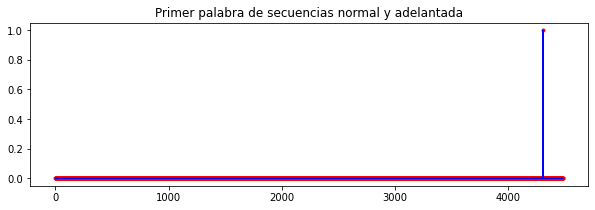

In [36]:
plt.figure(figsize=(10, 3))
plt.plot(decoder_input_data[-1][1], '.r')
plt.plot(decoder_target_data[-1][0], 'b')
plt.title('Primer palabra de secuencias normal y adelantada')
plt.show()

In [37]:
import pandas as pd
idx = np.argmax(list(map(len, input_tokenized)))
pd.DataFrame({
    'Text': input_tokenized[idx],
    'Vector': encoder_input_data[idx,:,input_token_index['he']],
    }
).T

,0,1,2,3,4,5,6
Text,``,look,",",'',she,said,.
Vector,0,0,0,0,0,0,0


# Modelo seq2seq

In [38]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

In [39]:
batch_size = 64
epochs     = 20
latent_dim = 1024

### Codificador

In [40]:
encoder_inputs = Input(shape = (None, num_encoder_tokens))

encoder_o, encoder_h, encoder_c = LSTM(
    units        = latent_dim,
    return_state = True
)(encoder_inputs)

encoder_states = [encoder_h, encoder_c]

print(encoder_inputs.shape)
print(encoder_o.shape, encoder_h.shape, encoder_c.shape)

(None, None, 2603)
(None, 1024) (None, 1024) (None, 1024)


### Decodificador

1. Para el decodificador usaremos de nuevo una LSTM
2. La entrada del decodificador es la salida del codificador
3. El estado inicial (de la primera etapa) del decodificador estara dado por los estados internos del decodificador.
4. Usaremos el estado interno de la 'ultima etapa del decodificador para la inferencia.
5. Se agrega una capa densa a la salida para obtener la secuencia codificada 


In [41]:
decoder_inputs = Input(shape = (None, num_decoder_tokens))

layer_lstm = LSTM(
    units = latent_dim,
    return_sequences = True,
    return_state = True
)

decoder_O, _, _ = layer_lstm(
    decoder_inputs,
    initial_state = encoder_states
)

layer_dense = Dense(
    units = num_decoder_tokens,
    activation = 'softmax'
)

decoder_outputs = layer_dense(decoder_O)

## Modelo Seq2seq

In [42]:
model = Model(
    inputs = [encoder_inputs, decoder_inputs],
    outputs = decoder_outputs
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2603)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4481)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1024), (None 14860288    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 1024), 22552576    input_2[0][0]                    
                                                                 lstm[0][1]                   

In [43]:
model.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.callbacks import TensorBoard 

In [45]:
my_callbacks = [
    EarlyStopping(patience = 5),
    #ModelCheckpoint(filepath = 's2s_words_MT.{epoch:04d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir = './logs_MT_words')
]

In [46]:
history = model.fit(
    x = [encoder_input_data, decoder_input_data],
    y = decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = True,
    validation_split = 0.2,
    callbacks = my_callbacks
)

Epoch 1/20
100/100 [==============================] - 43s 105ms/step - loss: 3.1487 - accuracy: 0.5686 - val_loss: 2.3480 - val_accuracy: 0.6220
Epoch 2/20
100/100 [==============================] - 9s 88ms/step - loss: 2.0357 - accuracy: 0.6662 - val_loss: 2.0763 - val_accuracy: 0.7059
Epoch 3/20
100/100 [==============================] - 9s 88ms/step - loss: 1.7123 - accuracy: 0.7354 - val_loss: 1.8262 - val_accuracy: 0.7425
Epoch 4/20
100/100 [==============================] - 9s 89ms/step - loss: 1.4842 - accuracy: 0.7619 - val_loss: 1.7464 - val_accuracy: 0.7536
Epoch 5/20
100/100 [==============================] - 9s 89ms/step - loss: 1.3673 - accuracy: 0.7727 - val_loss: 1.6795 - val_accuracy: 0.7617
Epoch 6/20
100/100 [==============================] - 9s 89ms/step - loss: 1.2436 - accuracy: 0.7848 - val_loss: 1.6735 - val_accuracy: 0.7650
Epoch 7/20
100/100 [==============================] - 9s 89ms/step - loss: 1.1181 - accuracy: 0.7981 - val_loss: 1.6277 - val_accuracy: 0.77

In [47]:
# Guarda el modelo
model.save(f"{root_path}/modelo_seq2seq_TRAINED.h5")

## Inferencia en Seq2Seq

1. El codificador permanece sin cambios
2. El decodificador:
  - Transformar la información semántica en forma completa por el codificador y luego pasar los estados ocultos de salida al decodificador para que los decodifique palabra por palabra generando así la nueva secuencia.
  - Se usarán los estados que resultan de la red LSTM, pues se usarán para pasar de un caracter al siguiente.
  - El decodificador tiene como estado inicial los estados de salida del codificador.
  - La entrada al decodificador será el anterior caracter predicho por el mismo, inicializando con la palabra START

In [49]:
# Codificador
encoder_model = Model(encoder_inputs, encoder_states)

# Entradas de decodificador
decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
# Combinados
decoder_states_inputs = [decoder_state_input_h, 
                         decoder_state_input_c]

Ahora usaremos las capas `layer_lstm` y `layer_dense`, que han sido entrenadas previamente

In [50]:
decoder_O, state_H, state_C = layer_lstm(
  decoder_inputs,
  initial_state = decoder_states_inputs    
)

decoder_outputs = layer_dense(decoder_O)

In [51]:
decoder_model = Model(
    inputs = [decoder_inputs] + decoder_states_inputs,
    outputs = [decoder_outputs] + [state_H, state_C]
)

In [52]:
# Diccionarios invertidos caracter-indice a indice-caracter
# para decodificar
reverse_input_token_index = {
    idx: token for token, idx in input_token_index.items()
}

reverse_target_token_index = {
    idx: token for token, idx in target_token_index.items()
}


In [57]:
# Función para decodificar la secuencia de entrada en 
def decode_sequence(input_seq):

  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_token_index['START']] = 1

  stop_condition = False
  decoded_sentence = ''

  while not stop_condition:
    output_token, state_H, state_C = decoder_model.predict(
        [target_seq] + states_value
    )

    sampled_token_index = np.argmax(output_token[0, -1, :])
    sampled_token = reverse_target_token_index[sampled_token_index]
    decoded_sentence += ' ' + sampled_token

    # Fin del procesamiento de la secuencia
    if (sampled_token == 'END' or len(decoded_sentence) >
        max_decoder_seq_len):
      stop_condition = True
    
    # Actualiza la entrada del decodificador para la
    # siguiente prediccion
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1

    # Actualiza los estados
    states_value = [state_H, state_C]

  return decoded_sentence

In [58]:
seq_index = 1000
input_seq = encoder_input_data[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)
print(input_texts[seq_index], ' --> ', decoded_sentence)

atlantis is real.  -->   la atlántida


In [60]:
print('Oracion en ingles --> traduccion por la red seq2seq al espaniol')

for seq_index in range(2000, 2050):
  # Secuencia codificada en one-hot
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print(input_texts[seq_index], ' --> ', decoded_sentence)

Oracion en ingles --> traduccion por la red seq2seq al espaniol
i think i got it.  -->   creo que tengo
i think it works.  -->   creo que funciona
i think it's tom.  -->   creo que es verdad
i told tom to go.  -->   le dije a tom
i told tom to go.  -->   le dije a tom
i told the truth.  -->   dije la verdad
i totally forgot.  -->   me olvidé totalmente
i totally get it.  -->   yo totalmente
i truly doubt it.  -->   de verdad lo
i understand tom.  -->   lo comprendo
i understand now.  -->   ahora lo entiendo
i understand why.  -->   comprendo el
i understand why.  -->   comprendo el
i understand why.  -->   comprendo el
i understand why.  -->   comprendo el
i understand you.  -->   lo entiendo .
i used to be fat.  -->   solía ser gordo
i visited boston.  -->   visité boston
i waited for you.  -->   te estuve esperando
i waited for you.  -->   te estuve esperando
i walk every day.  -->   me todos todos
i want mary back.  -->   quiero que vuelva
i want mary back.  -->   quiero que vuelva


# Referencias

1. Mariano Rivera (2018). **[Seq2Seq : Modelos de redes recurrentes para transformar secuencias a secuencias](http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/seq2seq/seq2seq.html)**. *Consultado el 18 de marzo del 2021.*